# Towards Cellular-Level Alignment: A Coarse-to-Fine Approach for Multistain Whole Slide Image Registration

This notebook demonstrates the complete workflow for Whole Slide Image (WSI) registration using rigid and non-rigid techniques with nuclei-based analysis.

## Overview
- **Rigid Registration**: Initial coarse alignment using traditional techniques

## 1. Setup and Imports

In [1]:
import sys
import os

# Add project root to PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # adjust if needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [2]:
# Enable inline plotting and auto-reload for development
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import all necessary modules
import SimpleITK as sitk 
from wsi_mif_registration.utils.imports import *
from wsi_mif_registration.config import *
from wsi_mif_registration.preprocessing.preprocessing import *
from wsi_mif_registration.preprocessing.padding import *
from wsi_mif_registration.registration.registration import *
from wsi_mif_registration.registration.nonrigid import *
from wsi_mif_registration.evaluation.evaluation import *
from wsi_mif_registration.visualization.visualization import *
from wsi_mif_registration.preprocessing.nuclei_analysis import *
from wsi_mif_registration.utils import *
# Setup Bokeh for notebook output
setup_bokeh_notebook()

print("✅ All modules imported successfully!")
print(f"Source WSI: {SOURCE_WSI_PATH}")
print(f"Target WSI: {TARGET_WSI_PATH}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


|2025-10-13|20:53:33.095| [WARNING] /home/u5552013/miniconda3/envs/tiatoolbox-reg-vis/lib/python3.9/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()



Loading BokehJS ...

✅ All modules imported successfully!
Source WSI: /home/u5552013/Nextcloud/HYRECO/Data/Image/ki67_533.tif
Target WSI: /home/u5552013/Nextcloud/HYRECO/Data/Image/he_533.tif


## 2. Configuration Check

Verify that all file paths are correct and files exist.

In [3]:
import os

# Check if files exist
files_to_check = [
    SOURCE_WSI_PATH,
    TARGET_WSI_PATH,
    FIXED_POINTS_PATH,
    MOVING_POINTS_PATH
]

print("File existence check:")
for file_path in files_to_check:
    exists = os.path.exists(file_path)
    status = "✅" if exists else "❌"
    print(f"{status} {file_path}")

# Display current parameters
print("\nCurrent Parameters:")
print(f"- Preprocessing Resolution: {PREPROCESSING_RESOLUTION}")
print(f"- Registration Resolution: {REGISTRATION_RESOLUTION}")
print(f"- Patch Size: {PATCH_SIZE}")
print(f"- Fixed Threshold: {FIXED_THRESHOLD}")
print(f"- Moving Threshold: {MOVING_THRESHOLD}")
print(f"- Min Nuclei Area: {MIN_NUCLEI_AREA}")

File existence check:
✅ /home/u5552013/Nextcloud/HYRECO/Data/Image/ki67_533.tif
✅ /home/u5552013/Nextcloud/HYRECO/Data/Image/he_533.tif
✅ /home/u5552013/Nextcloud/HYRECO/Eval/he_533.csv
✅ /home/u5552013/Nextcloud/HYRECO/Eval/ki67_533.csv

Current Parameters:
- Preprocessing Resolution: 0.625
- Registration Resolution: 40
- Patch Size: (1000, 1000)
- Fixed Threshold: 100
- Moving Threshold: 50
- Min Nuclei Area: 200


## 3. Load and Preprocess WSI Images

In [4]:
# Load WSI images
print("Loading WSI images...")
source_wsi, target_wsi, source, target = load_wsi_images(
    SOURCE_WSI_PATH, TARGET_WSI_PATH, PREPROCESSING_RESOLUTION
)

print(f"\nLoaded images:")
print(f"Source shape: {source.shape}")
print(f"Target shape: {target.shape}")

|2025-10-13|20:53:42.611| [ERROR] File does not have a .json extension.


Loading WSI images...


|2025-10-13|20:53:42.995| [ERROR] File does not have a .json extension.
|2025-10-13|20:53:43.392| [ERROR] File does not have a .json extension.
|2025-10-13|20:53:43.775| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).
|2025-10-13|20:53:43.779| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
|2025-10-13|20:53:44.341| [ERROR] File does not have a .json extension.
|2025-10-13|20:53:44.740| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).
|2025-10-13|20:53:44.743| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.


Source original shape: (3451, 1520, 3)
Target original shape: (3450, 1520, 3)

Loaded images:
Source shape: (3451, 1520, 3)
Target shape: (3450, 1520, 3)


In [5]:
# Preprocess images
print("Preprocessing images...")
# source_prep, target_prep = preprocess_images(source, target)
source_prep,target_prep, padding_params=pad_images(source, target)
# Extract tissue masks
print("Extracting tissue masks...")
source_mask, target_mask = extract_tissue_masks(source_prep, target_prep, artefacts=None)

print("✅ Preprocessing completed!")

Preprocessing images...
Extracting tissue masks...
✅ Preprocessing completed!


## 4. Visualize Original Images and Tissue Masks

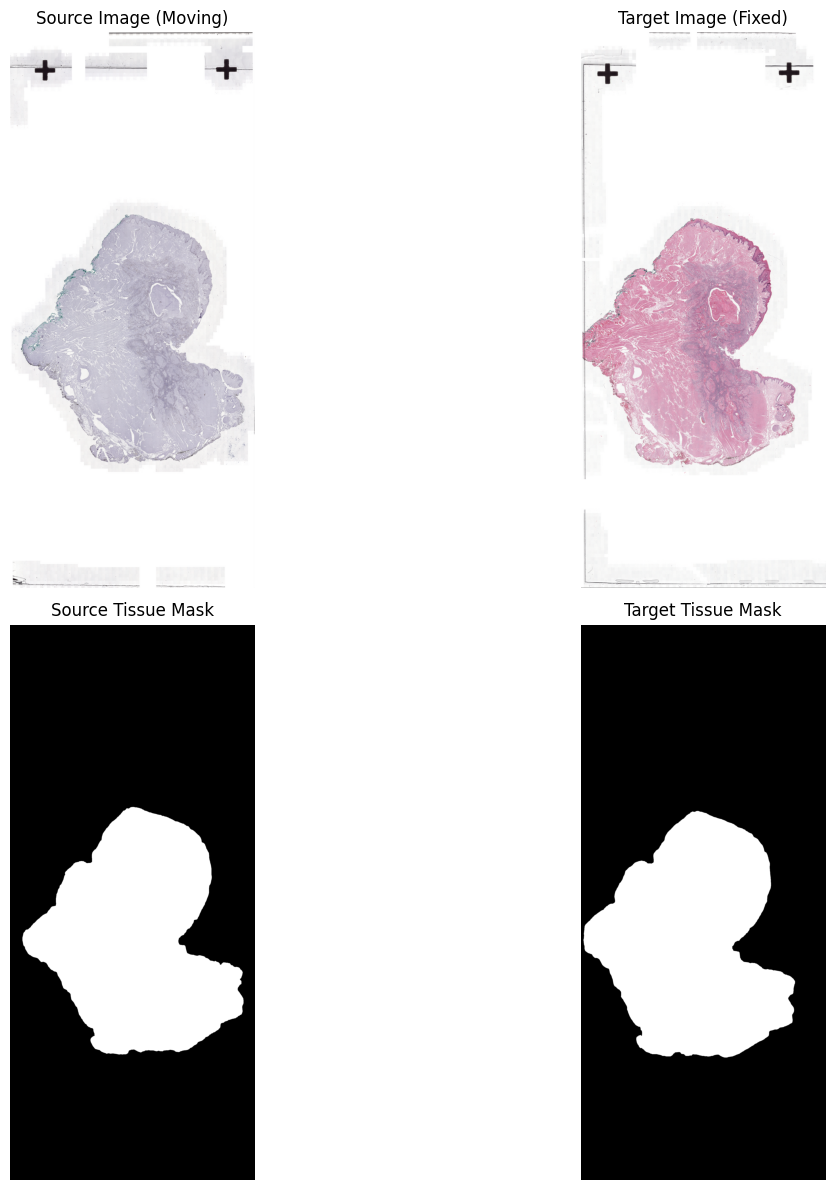

In [6]:
# Display original images side by side
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].imshow(source_prep)
axes[0, 0].set_title('Source Image (Moving)')
axes[0, 0].axis('off')

axes[0, 1].imshow(target_prep)
axes[0, 1].set_title('Target Image (Fixed)')
axes[0, 1].axis('off')

axes[1, 0].imshow(source_mask, cmap='gray')
axes[1, 0].set_title('Source Tissue Mask')
axes[1, 0].axis('off')

axes[1, 1].imshow(target_mask, cmap='gray')
axes[1, 1].set_title('Target Tissue Mask')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## 5. Perform Rigid Registration

Performing rigid registration...
ngf 0.03852772267620144
ngf 0.045903617557452835
loading weights from: /home/u5552013/Desktop/WSI_mIF_Registration/accelerated_features/modules/../weights/xfeat.pt
ngf 0.041983008746818824
ngf 0.04672027149112584

Rigid transformation matrix:
[[  0.99539452  -0.07569868  51.68875352]
 [  0.07569868   0.99539452 -30.64145523]
 [  0.           0.           1.        ]]


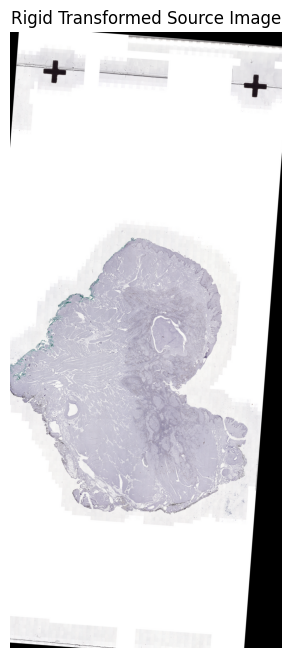

✅ Rigid registration completed!


In [7]:
# Perform rigid registration
print("Performing rigid registration...")
moving_img_transformed, final_transform = perform_rigid_registration(
    source_prep, target_prep, source_mask, target_mask
)

print("\nRigid transformation matrix:")
print(final_transform)

# Visualize transformed image
plt.figure(figsize=(12, 8))
plt.imshow(moving_img_transformed)
plt.title('Rigid Transformed Source Image')
plt.axis('off')
plt.show()

print("✅ Rigid registration completed!")

In [8]:
u_x, u_y = util.rigid_dot(source_prep, np.linalg.inv(final_transform))

deformation_field = np.stack(( u_x, u_y), axis=-1)
sitk_image = sitk.GetImageFromArray(deformation_field)
sitk.WriteImage(sitk_image, './533_rigid.mha')

## 6. Non Rigid Registration

In [9]:
displacement_field,warped_source= elastic_image_registration(
   moving_img_transformed,
   target_prep,
    similarity_metric_params={'win_size': 7}, 
     compute_device='cuda'  # Use the same device
)
print("non rigid displacement field",displacement_field.shape)

non rigid displacement field torch.Size([1, 3451, 1520, 2])


## 7. Visualization

In [ ]:
%%bash 
tiatoolbox visualize --slides "/home/u5552013/Nextcloud/HYRECO_VIS/slides" --overlays "/home/u5552013/Nextcloud/HYRECO_VIS/overlays"


## 8. Scale Transformation and Extract Patches

In [10]:
# Scale transformation for high resolution analysis
transform_40x = scale_transformation_matrix(
    final_transform, PREPROCESSING_RESOLUTION, REGISTRATION_RESOLUTION
)

print("Scaled transformation matrix (40x):")
print(transform_40x)

# Extract patches from target WSI
print("\nExtracting patches...")
fixed_patch_extractor = extract_patches_from_wsi(
    target_wsi, target_mask, PATCH_SIZE, PATCH_STRIDE
)

print(f"Total patches extracted: {len(fixed_patch_extractor)}")

|2025-10-13|20:54:50.872| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


Scaled transformation matrix (40x):
[[ 9.95394516e-01 -7.56986785e-02  3.30808023e+03]
 [ 7.56986785e-02  9.95394516e-01 -1.96105313e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Extracting patches...
Total patches extracted: 5495


## 7. Visualize Sample Patches

Visualizing patch 100 at location (40000, 80000)


|2025-10-13|20:54:56.752| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


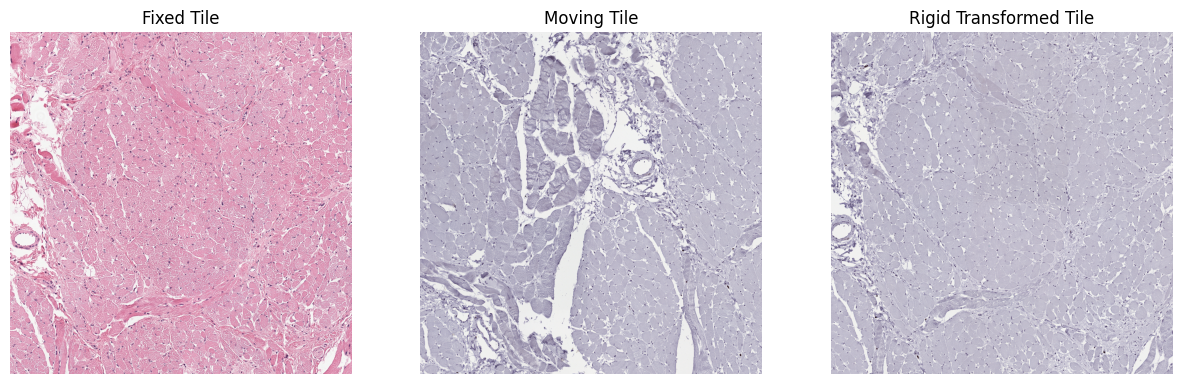

In [11]:
# Select a patch for visualization
patch_idx = 100  # You can change this index
loc = fixed_patch_extractor.coordinate_list[patch_idx]
location = (loc[0], loc[1])

print(f"Visualizing patch {patch_idx} at location {location}")

# Extract regions for comparison
fixed_tile = target_wsi.read_rect(location, VISUALIZATION_SIZE, resolution=40, units="power")
moving_tile = source_wsi.read_rect(location, VISUALIZATION_SIZE, resolution=40, units="power")

# Create transformer and extract transformed tile
tfm = AffineWSITransformer(source_wsi, transform_40x)
transformed_tile = tfm.read_rect(location=location, size=VISUALIZATION_SIZE, resolution=0, units="level")

# Visualize patches
visualize_patches(fixed_tile, moving_tile, transformed_tile)

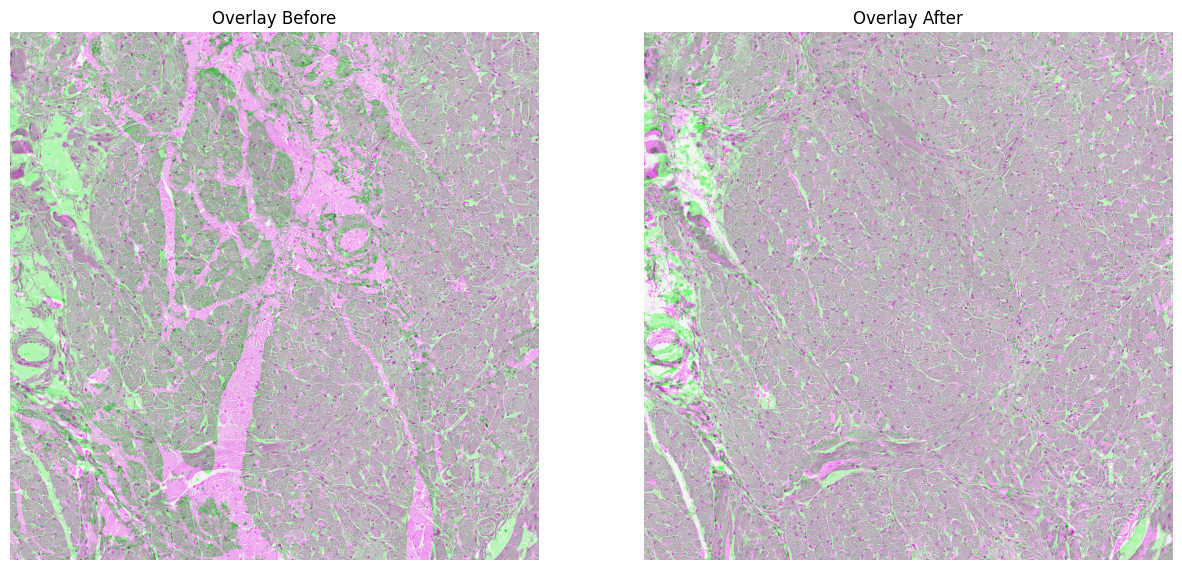

In [12]:
visualize_overlays(fixed_tile, moving_tile, transformed_tile)

In [13]:

FIXED_NUCLEI_CSV="/home/u5552013/Nextcloud/HYRECO/Data/nuclei_points/he_533_nuclei.csv"
MOVING_NUCLEI_CSV="/home/u5552013/Nextcloud/HYRECO/Data/nuclei_points/ki67_533_nuclei.csv"

In [191]:
all_fixed_nuclei_data, all_moving_nuclei_data = process_nuclei_in_patches(fixed_patch_extractor, tfm,100,100)


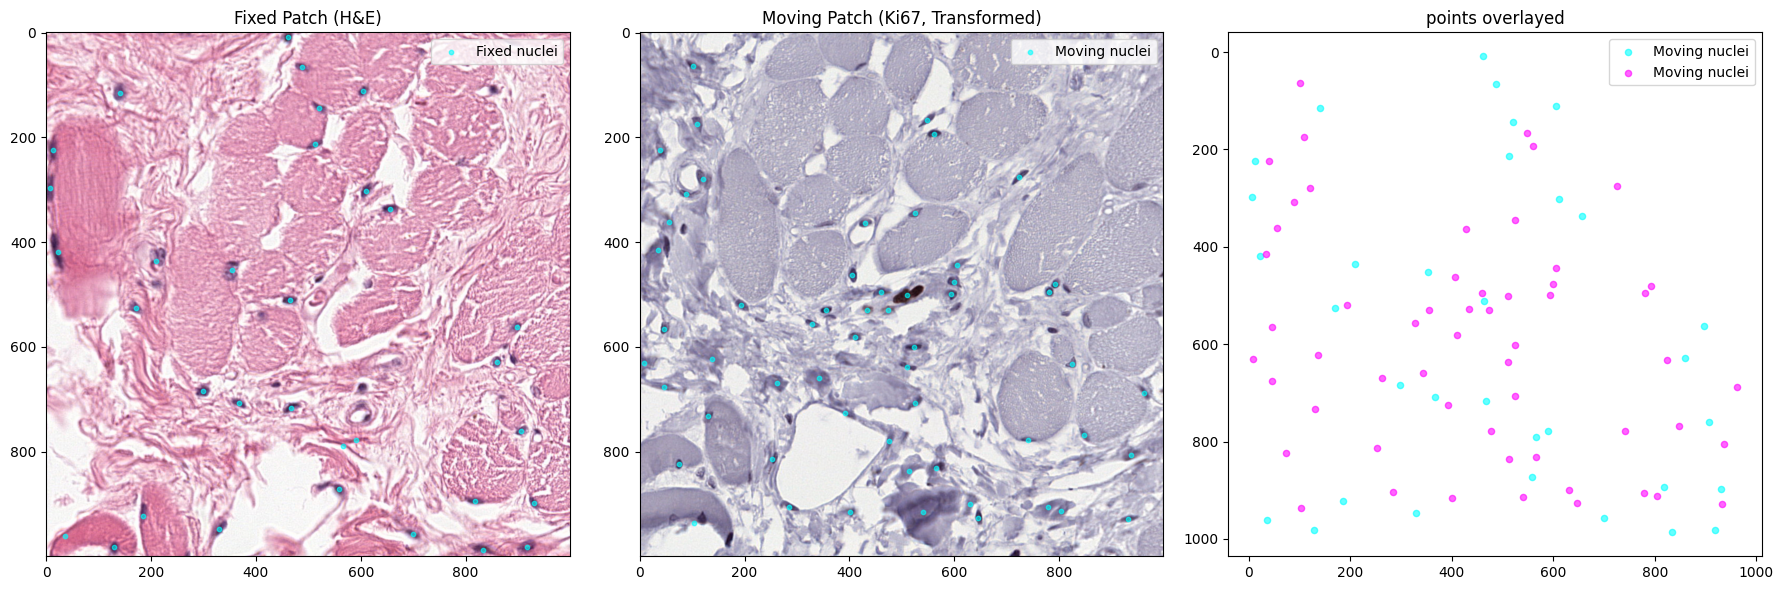

In [198]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert nuclei detection lists to DataFrames
fixed_df = pd.DataFrame(all_fixed_nuclei_data)
moving_df = pd.DataFrame(all_moving_nuclei_data)

# Define the visualization region — from one of the detected nuclei or patch info
patch_info = all_fixed_nuclei_data[0]
location = (patch_info['patch_x1'], patch_info['patch_y1'])   # top-left of patch 70
VISUALIZATION_SIZE = (1000, 1000)  # width, height in pixels

# Read aligned regions
fixed_patch = fixed_patch_extractor[100]

moving_patch = tfm.read_rect(
    location=location, size=VISUALIZATION_SIZE, resolution=0, units="level"
)

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)


# Fixed patch
axes[0].imshow(fixed_patch)
axes[0].scatter(
    fixed_df["local_x"], fixed_df["local_y"],
    c="cyan", s=10, alpha=0.6, label="Fixed nuclei"
)
axes[0].set_title("Fixed Patch (H&E)")
# axes[0].invert_yaxis()
axes[0].legend()

# Moving patch
axes[1].imshow(moving_patch)
axes[1].scatter(
    moving_df["local_x"], moving_df["local_y"],
    c="cyan", s=10, alpha=0.6, label="Moving nuclei"
)
axes[1].set_title("Moving Patch (Ki67, Transformed)")
# axes[1].invert_yaxis()
axes[1].legend()

axes[2].scatter(
    fixed_df["local_x"], fixed_df["local_y"],
    c="cyan", s=20, alpha=0.6, label="Moving nuclei"
)
axes[2].scatter(
    moving_df["local_x"], moving_df["local_y"],
    c="magenta", s=20, alpha=0.6, label="Moving nuclei"
)
axes[2].set_title("points overlayed")
axes[2].invert_yaxis()
axes[2].legend()
plt.tight_layout()
plt.show()


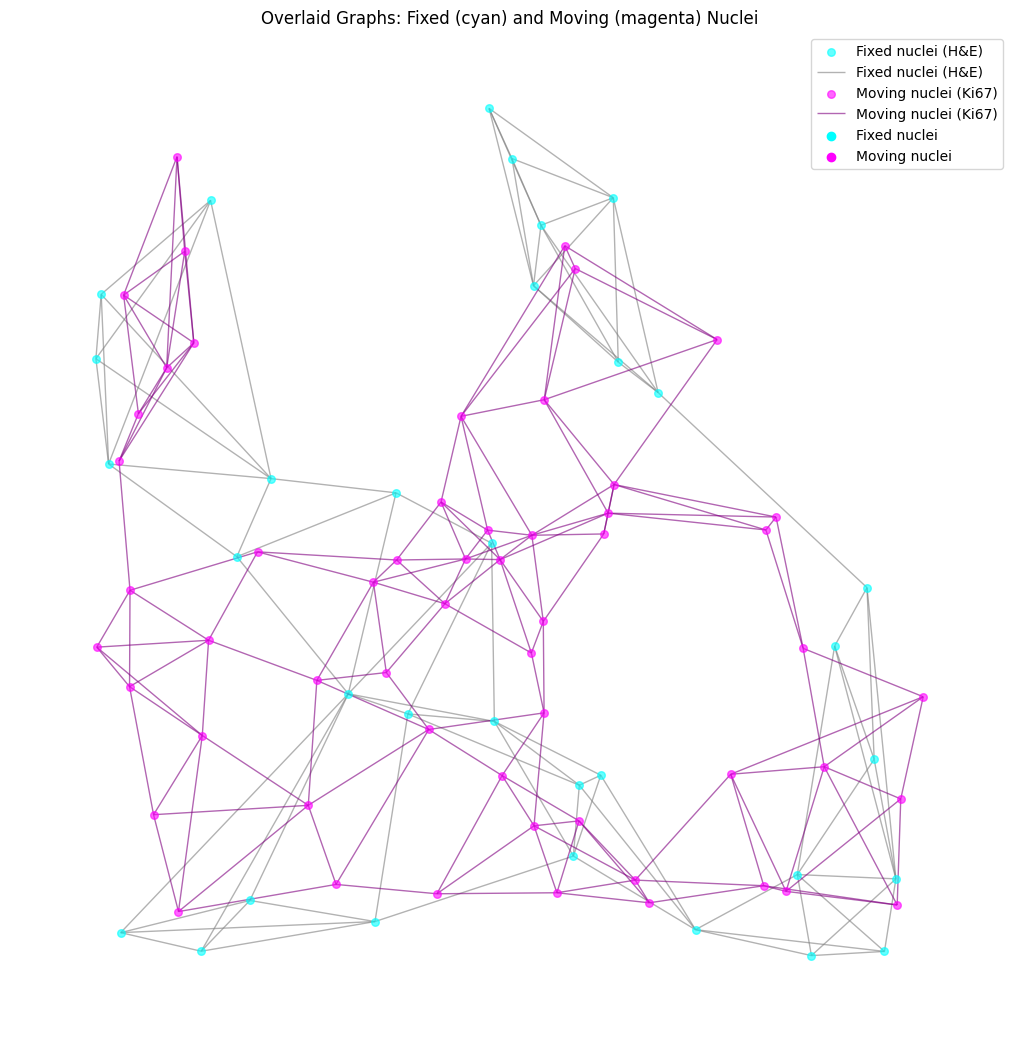

In [194]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.neighbors import NearestNeighbors

# --- Step 1: Get coordinates ---
fixed_coords = fixed_df[["local_x", "local_y"]].to_numpy()
moving_coords = moving_df[["local_x", "local_y"]].to_numpy()

# --- Step 2: Build Graphs ---
def build_graph(coords, k=4):
    G = nx.Graph()
    for i, (x, y) in enumerate(coords):
        G.add_node(i, pos=(x, y))
    
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(coords)
    _, indices = nbrs.kneighbors(coords)

    for i, neighbors in enumerate(indices):
        for j in neighbors[1:]:  # skip self
            G.add_edge(i, j)
    return G

fixed_G = build_graph(fixed_coords, k=4)
moving_G = build_graph(moving_coords, k=4)

# --- Step 3: Plot both graphs ---
plt.figure(figsize=(10, 10))

# Show fixed graph
nx.draw(
    fixed_G,
    pos=nx.get_node_attributes(fixed_G, 'pos'),
    node_size=30,
    node_color='cyan',
    edge_color='gray',
    alpha=0.6,
    label="Fixed nuclei (H&E)"
)

# Show moving graph
nx.draw(
    moving_G,
    pos=nx.get_node_attributes(moving_G, 'pos'),
    node_size=30,
    node_color='magenta',
    edge_color='purple',
    alpha=0.6,
    label="Moving nuclei (Ki67)"
)

plt.gca().invert_yaxis()
plt.title("Overlaid Graphs: Fixed (cyan) and Moving (magenta) Nuclei")
plt.axis("equal")

# Add custom legend manually
plt.scatter([], [], c='cyan', label='Fixed nuclei')
plt.scatter([], [], c='magenta', label='Moving nuclei')
plt.legend(loc='upper right')

plt.show()


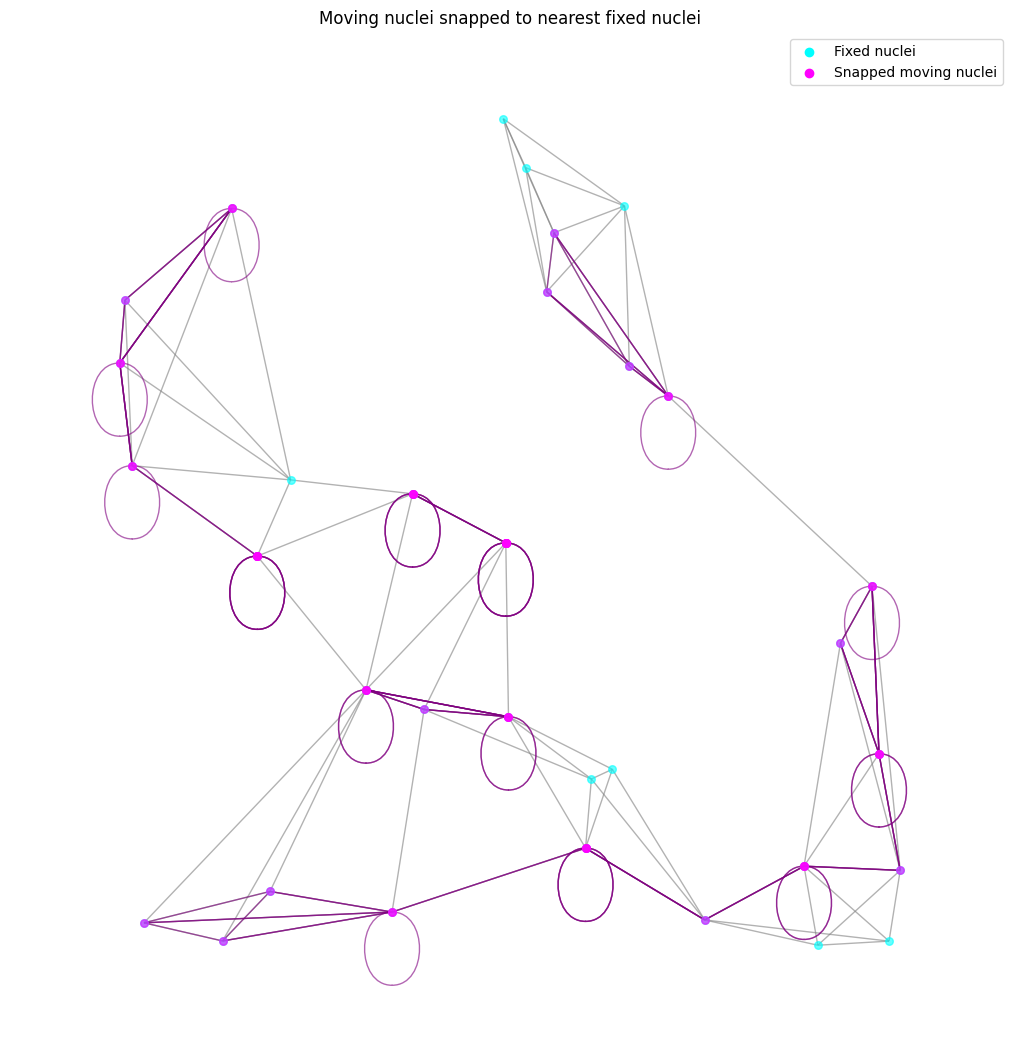

In [197]:
import numpy as np
from scipy.spatial import cKDTree
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Step 1: Get coordinates
fixed_coords = fixed_df[["local_x", "local_y"]].to_numpy()
moving_coords = moving_df[["local_x", "local_y"]].to_numpy()

# Step 2: Build KD-tree for fixed nuclei
fixed_tree = cKDTree(fixed_coords)

# Step 3: For each moving nucleus, find nearest fixed nucleus
distances, indices = fixed_tree.query(moving_coords, k=1)
# Snap moving nuclei to nearest fixed nuclei
snapped_moving_coords = fixed_coords[indices]

# Step 4: Build graphs using k-NN
def build_graph(coords, k=4):
    G = nx.Graph()
    for i, (x, y) in enumerate(coords):
        G.add_node(i, pos=(x, y))
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(coords)
    _, neighbors_indices = nbrs.kneighbors(coords)
    for i, neighbors in enumerate(neighbors_indices):
        for j in neighbors[1:]:  # skip self
            G.add_edge(i, j)
    return G

fixed_G = build_graph(fixed_coords, k=4)
snapped_moving_G = build_graph(snapped_moving_coords, k=4)

# Step 5: Plot
plt.figure(figsize=(10, 10))

# Draw fixed graph
nx.draw(
    fixed_G,
    pos=nx.get_node_attributes(fixed_G, 'pos'),
    node_size=30,
    node_color='cyan',
    edge_color='gray',
    alpha=0.6
)

# Draw snapped moving graph
nx.draw(
    snapped_moving_G,
    pos=nx.get_node_attributes(snapped_moving_G, 'pos'),
    node_size=30,
    node_color='magenta',
    edge_color='purple',
    alpha=0.6
)

plt.gca().invert_yaxis()
plt.title("Moving nuclei snapped to nearest fixed nuclei")
plt.axis('equal')
plt.scatter([], [], c='cyan', label='Fixed nuclei')
plt.scatter([], [], c='magenta', label='Snapped moving nuclei')
plt.legend(loc='upper right')
plt.show()


In [ ]:
disp_field_np=util.tc_df_to_np_df(displacement_field)
w_x,w_y=util.compose_vector_fields(u_x, u_y, disp_field_np[0], disp_field_np[1])

deformation_field = np.stack(( w_x, w_y), axis=-1)
sitk_image = sitk.GetImageFromArray(deformation_field)
sitk.WriteImage(sitk_image, './nonrigid.mha')